In [1]:
import pandas as pd
import openpyxl
import pandas as pd
from sklearn.cluster import DBSCAN
import numpy as np

## DBSCAN

In [2]:
noc_roma = pd.read_csv("../NOC_ROMA_202403110800-202403111600_clusters_la.csv")

In [3]:
noc_roma

,cluster_id,alarm_id,ne_id,NOTE SPV,domain,network,ne_type,std_probable_cause_no,geo_code,first_occurrence,last_occurrence
0,23801,"EFMTX,65eeac8f89e9530001bd7c5d",romaitbh/ad64/1,CORRELAZIONE OK CLUSTER 23801,tx,sdh,ad64,guasto matrice,roma,2024-03-11 08:02:38,2024-03-11 19:36:19
1,23801,"EFMTX,65eeac8489e9530001bd7c33",romaitbh/ad64/1,CORRELAZIONE OK CLUSTER 23801,tx,sdh,ad64,guasto matrice,roma,2024-03-11 08:02:27,2024-03-11 19:36:19
2,23801,"EFMTX,65eeac9089e9530001bd7c6b",romaitbh/ad64/1,CORRELAZIONE OK CLUSTER 23801,tx,sdh,ad64,guasto matrice,roma,2024-03-11 08:02:38,2024-03-11 19:36:25
3,23801,"EFMTX,65eeac8389e9530001bd7c2d",romaitbh/ad64/1,CORRELAZIONE OK CLUSTER 23801,tx,sdh,ad64,guasto matrice,roma,2024-03-11 08:02:27,2024-03-11 19:36:19
4,23801,"EFMTX,65eeac8489e9530001bd7c35",romaitbh/ad64/1,CORRELAZIONE OK CLUSTER 23801,tx,sdh,ad64,guasto matrice,roma,2024-03-11 08:02:27,2024-03-11 19:36:25
...,...,...,...,...,...,...,...,...,...,...,...
313,28624,"EFMTX,65ef1d3c6423e50001f2f987",romaitdm/adm4/5,CORRELAZIONE ERRATA SU CLUSTER 28624,tx,sdh,adm4,loss of pointer lop,roma,2024-03-11 16:03:24,2024-03-11 21:21:52
314,28624,"EFMTX,65ef1d146423e50001f2f954",romaitdm/adm4/5,CORRELAZIONE ERRATA SU CLUSTER 28624,tx,sdh,adm4,loss of pointer lop,roma,2024-03-11 16:02:43,2024-03-11 19:03:50
315,28624,"EFMTX,65ef1d146423e50001f2f956",romaitdm/adm4/5,CORRELAZIONE ERRATA SU CLUSTER 28624,tx,sdh,adm4,loss of pointer lop,roma,2024-03-11 16:02:43,2024-03-11 19:03:50
316,28624,"EFMTX,65ef1bf947128a0001aa8841",romaitde/ad16/3,CORRELAZIONE ERRATA SU CLUSTER 28624,tx,sdh,ad16,loss of pointer lop,roma,2024-03-11 15:58:01,2024-03-11 16:21:39


## Statistics


In [4]:
noc_roma_grouped = noc_roma.groupby("cluster_id")
numero_cluster = noc_roma["cluster_id"].nunique()

cluster_corretti = []
cluster_totalmente_errati = []
cluster_parzialmente_corretti = []

for cluster_id, gruppo in noc_roma.groupby("cluster_id"):
    if gruppo["NOTE SPV"].str.contains("CORRELAZIONE OK").all():
        cluster_corretti.append(cluster_id)
    elif gruppo["NOTE SPV"].str.contains("CORRELAZIONE ERRATA").all():
        cluster_totalmente_errati.append(cluster_id)
    else:
        cluster_parzialmente_corretti.append(cluster_id)

print("Numero Cluster:", numero_cluster)
print(f"Numero di cluster corretti: {len(cluster_corretti)}")
print(f"Numero di cluster totalmente errati: {len(cluster_totalmente_errati)}")
print(f"Numero di cluster parzialmente corretti: {len(cluster_parzialmente_corretti)}")


Numero Cluster: 35
Numero di cluster corretti: 13
Numero di cluster totalmente errati: 12
Numero di cluster parzialmente corretti: 10


### Single epsilon value DBSCAN

In [5]:
noc_roma["first_occurrence"] = pd.to_datetime(noc_roma["first_occurrence"])


cluster_labels = []
df_list = []


for cluster_id, group in noc_roma.groupby("cluster_id"):
    # Convertire i tempi in numeri
    X = group[["first_occurrence"]].apply(lambda x: x.astype(np.int64) // 10**9).values
    # Applicazione di DBSCAN
    dbscan = DBSCAN(
        eps=500, min_samples=2
    )  # eps è in secondi (86400 secondi = 1 giorno)
    labels = dbscan.fit_predict(X)
    cluster_labels.extend(labels)
    # Creazione di un DataFrame temporaneo con i risultati
    temp_df = pd.DataFrame(
        {
            "cluster_id": cluster_id,
            "CLUSTER_LABEL": labels,
        }
    )

    df_list.append(temp_df)


final_df = pd.concat(df_list, ignore_index=True)
filtered_noc_roma = noc_roma[["NOTE SPV"]]


merge_df = pd.merge(
    final_df, filtered_noc_roma, left_index=True, right_index=True, how="left"
)

In [6]:
merge_grouped = merge_df.groupby("cluster_id")

reconstructed_correct_clusters = 0
for cluster_id, group in merge_grouped:

    if cluster_id in cluster_corretti:
        if group["CLUSTER_LABEL"].nunique() == 1:
            reconstructed_correct_clusters += 1

print(
    f"Numero di cluster corretti ricostruiti correttamente: {reconstructed_correct_clusters} di {len(cluster_corretti)}"
)


partially_correct_clusters_predicted = 0

for cluster_id, group in merge_grouped:

    if cluster_id in cluster_parzialmente_corretti:
        # Filtra gli allarmi con "CORRELAZIONE OK"
        allarmi_ok = group[group["NOTE SPV"].str.contains("CORRELAZIONE OK")]
        # Filtra gli allarmi con "CORRELAZIONE ERRATA"
        allarmi_errata = group[
            group["NOTE SPV"].str.contains("CORRELAZIONE ERRATA")
        ]

        # Verifica che tutti gli allarmi OK abbiano la stessa label
        label_unica_ok = allarmi_ok["CLUSTER_LABEL"].nunique() == 1

        # Verifica che gli allarmi ERRATA abbiano una label diversa da quella degli allarmi OK
        if not allarmi_errata.empty and label_unica_ok:
            label_ok = allarmi_ok["CLUSTER_LABEL"].iloc[0]
            # Verifica che tutte le label ERRATA siano diverse da quella OK
            label_diverse_errata = (
                not allarmi_errata["CLUSTER_LABEL"].isin([label_ok]).any()
            )

            if label_diverse_errata:
                partially_correct_clusters_predicted += 1

print(
    f"Numero di cluster corretti ricostruiti correttamente: {partially_correct_clusters_predicted} di {len(cluster_parzialmente_corretti)}"
)

merge_df.to_excel("DBSCAN_df.xlsx", index=False)

Numero di cluster corretti ricostruiti correttamente: 11 di 13


Numero di cluster corretti ricostruiti correttamente: 0 di 10


### Multiple epsilon DBSCAN

In [7]:
import matplotlib.pyplot as plt
from tqdm import tqdm

epsilon_values = np.arange(0.1, 800, 0.2)


results = []
reconstructed_correct_clusters_values = []
partially_correct_clusters_predicted_values = []
cluster_corretti_values = []
cluster_parzialmente_corretti_values = []

for epsilon in tqdm(epsilon_values, desc="Valori di epsilon "):
    cluster_labels = []
    df_list = []

    for cluster_id, group in noc_roma.groupby("cluster_id"):
        # Convertire i tempi in numeri
        X = (
            group[["first_occurrence"]]
            .apply(lambda x: x.astype(np.int64) // 10**9)
            .values
        )
        # Applicazione di DBSCAN con epsilon variabile
        dbscan = DBSCAN(eps=epsilon, min_samples=2)  # eps è in secondi
        labels = dbscan.fit_predict(X)
        cluster_labels.extend(labels)
        # Creazione di un DataFrame temporaneo con i risultati
        temp_df = pd.DataFrame(
            {
                "cluster_id": cluster_id,
                "CLUSTER_LABEL": labels,
            }
        )
        df_list.append(temp_df)

    final_df = pd.concat(df_list, ignore_index=True)
    filtered_noc_roma = noc_roma[["NOTE SPV"]]

    merge_df = pd.merge(
        final_df, filtered_noc_roma, left_index=True, right_index=True, how="left"
    )

    merge_grouped = merge_df.groupby("cluster_id")

    reconstructed_correct_clusters = 0
    for cluster_id, group in merge_grouped:

        if cluster_id in cluster_corretti:
            if group["CLUSTER_LABEL"].nunique() == 1:
                reconstructed_correct_clusters += 1

    reconstructed_correct_clusters_values.append(reconstructed_correct_clusters)
    cluster_corretti_values.append(len(cluster_corretti))

    partially_correct_clusters_predicted = 0

    for cluster_id, group in merge_grouped:

        if cluster_id in cluster_parzialmente_corretti:
            if cluster_id in cluster_parzialmente_corretti:
                # Filtra gli allarmi con "CORRELAZIONE OK"
                allarmi_ok = group[group["NOTE SPV"].str.contains("CORRELAZIONE OK")]
                # Filtra gli allarmi con "CORRELAZIONE ERRATA"
                allarmi_errata = group[
                    group["NOTE SPV"].str.contains("CORRELAZIONE ERRATA")
                ]

                # Verifica che tutti gli allarmi OK abbiano la stessa label
                label_unica_ok = allarmi_ok["CLUSTER_LABEL"].nunique() == 1

                # Verifica che gli allarmi ERRATA abbiano una label diversa da quella degli allarmi OK
                if not allarmi_errata.empty and label_unica_ok:
                    label_ok = allarmi_ok["CLUSTER_LABEL"].iloc[0]
                    # Verifica che tutte le label ERRATA siano diverse da quella OK
                    label_diverse_errata = (
                        not allarmi_errata["CLUSTER_LABEL"].isin([label_ok]).any()
                    )

                    if label_diverse_errata:
                        partially_correct_clusters_predicted += 1
    partially_correct_clusters_predicted_values.append(partially_correct_clusters_predicted)
    cluster_parzialmente_corretti_values.append(len(cluster_parzialmente_corretti))


plt.figure(figsize=(10, 6))


plt.plot(epsilon_values, partially_correct_clusters_predicted_values, label="Cluster Parzialmente Corretti Predetti")
plt.plot(
    epsilon_values, reconstructed_correct_clusters_values, label="Cluster Corretti Ricostruiti"
)
plt.plot(epsilon_values, cluster_corretti_values, label="Totale Cluster Corretti")
plt.plot(
    epsilon_values,
    cluster_parzialmente_corretti_values,
    label="Totale Cluster Parzialmente Corretti",
)


plt.xlabel("Epsilon(secondi)")
plt.ylabel("# Cluster")
plt.title("Valori al Variare di Epsilon")
plt.legend()
plt.grid(True)


plt.show()

Valori di epsilon :  43%|████▎     | 1728/4000 [02:11<02:54, 13.01it/s]

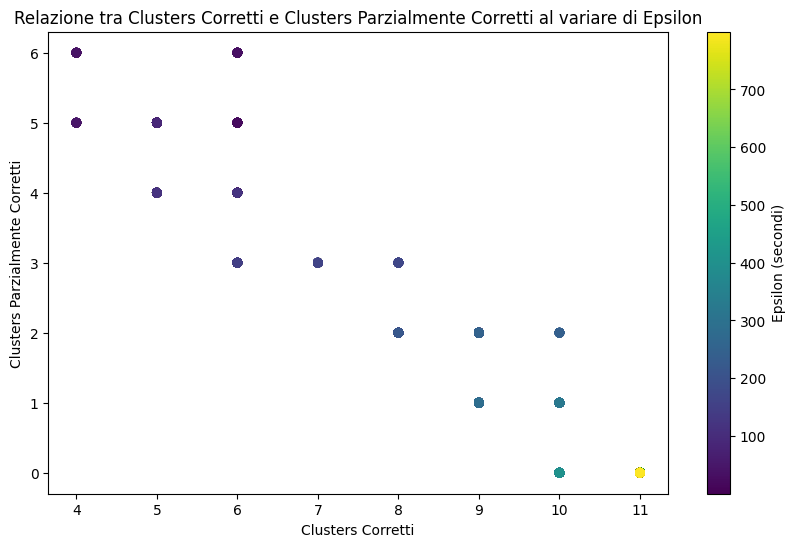

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
epsilon_values = np.arange(0.1, 800, 0.2)

# Assumendo che predict_correct_clusters_values e predict_wrong_clusters_values siano definiti
punti = list(zip(reconstructed_correct_clusters_values, partially_correct_clusters_predicted_values, epsilon_values))
punti = list(dict.fromkeys(punti))
x_valori, y_valori, eps = zip(*punti)
scatter = plt.scatter(x_valori, y_valori, c=eps, cmap="viridis")

cbar = plt.colorbar(scatter)
cbar.set_label("Epsilon (secondi)")

plt.xlabel("Clusters Corretti")
plt.ylabel("Clusters Parzialmente Corretti")
plt.title("Relazione tra Clusters Corretti e Clusters Parzialmente Corretti al variare di Epsilon")
plt.show()

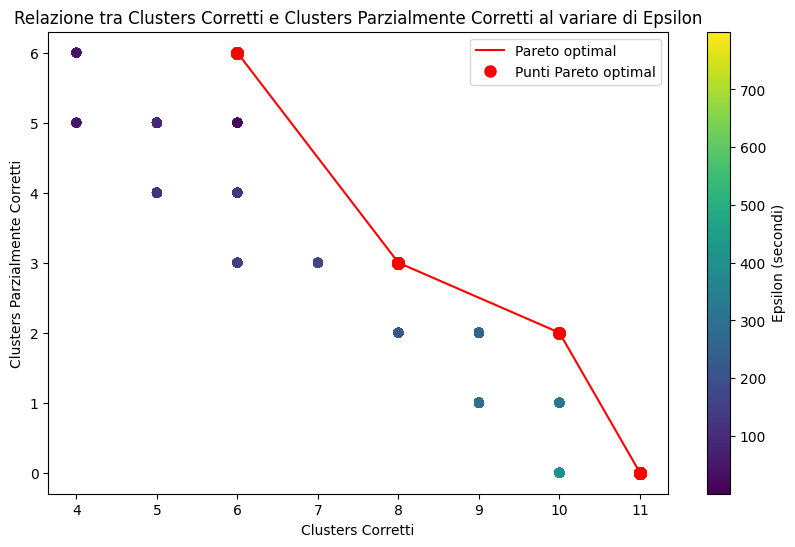

In [ ]:
import oapackage

plt.figure(figsize=(10, 6))

scatter = plt.scatter(x_valori, y_valori, c=eps, cmap="viridis")

pareto = oapackage.ParetoDoubleLong()

datapoints = np.array([x_valori, y_valori])

for ii in range(0, datapoints.shape[1]):
    w = oapackage.doubleVector()
    w.push_back(float(datapoints[0, ii]))
    w.push_back(float(datapoints[1, ii]))
    pareto.addvalue(w, ii)

lst = pareto.allindices()

optimal_datapoints = datapoints[:, lst]

plt.plot(optimal_datapoints[0, :], optimal_datapoints[1, :], "r-", label="Pareto optimal")
hp = plt.plot(optimal_datapoints[0, :], optimal_datapoints[1, :], ".r", markersize=16, label="Punti Pareto optimal")

cbar = plt.colorbar(scatter)
cbar.set_label("Epsilon (secondi)")

plt.xlabel("Clusters Corretti")
plt.ylabel("Clusters Parzialmente Corretti")
plt.title("Relazione tra Clusters Corretti e Clusters Parzialmente Corretti al variare di Epsilon")
plt.legend()
plt.show()